In [4]:
import sys
sys.path.append("../../modules/")
import helper as m_helper
# ---
import theano
from theano import tensor as T
import lasagne
import numpy as np
from lasagne.layers import *
from lasagne.nonlinearities import *
# ---
import random
# ---
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
train_set, _, _ = m_helper.load_mnist("../../data/mnist.pkl.gz")
Xt, yt = train_set

**From [this link](https://github.com/Lasagne/Lasagne/issues/168), we wish to implement this contrastive loss function:**

$ E = \frac{1}{2N} \sum\limits_{n=1}^N \left(y\right) d + \left(1-y\right) \max \left(margin-d, 0\right) $ where $ d = \left| \left| a_n - b_n \right| \right|_2^2 $

In [8]:
cls_to_idx = dict()
for k in range(0,10):
    cls_to_idx[k] = np.where(yt == k)[0].tolist()

In [9]:
yt

array([5, 0, 4, ..., 8, 4, 8])

In [76]:
def get_actual_pair(cls_to_idx, Xt):
    random_class = np.random.randint(0, len(cls_to_idx.keys()))      
    random_idx_1_for_class = cls_to_idx[random_class][ np.random.randint(0, len(cls_to_idx[random_class])) ]
    random_idx_2_for_class = cls_to_idx[random_class][ np.random.randint(0, len(cls_to_idx[random_class])) ]
    return (random_class, random_idx_1_for_class), (random_class, random_idx_2_for_class)

In [77]:
def get_imposter_pair(cls_to_idx, Xt):
    random_class_1 = 0
    random_class_2 = 0
    while random_class_1 == random_class_2:
        random_class_1 = np.random.randint(0, len(cls_to_idx.keys()))
        random_class_2 = np.random.randint(0, len(cls_to_idx.keys()))        
    random_idx_in_class_1 = cls_to_idx[random_class_1][ np.random.randint(0, len(cls_to_idx[random_class_1])) ]
    random_idx_in_class_2 = cls_to_idx[random_class_2][ np.random.randint(0, len(cls_to_idx[random_class_2])) ]
    return (random_class_1, random_idx_in_class_1), (random_class_2, random_idx_in_class_2)

In [78]:
get_imposter_pair(cls_to_idx, Xt)

((9, 12131), (6, 18344))

In [125]:
def get_batch(size):
    X_batch = []
    y_batch = []
    for i in range(0, size/2):
        c = np.random.randint(0,2)
        if c == 0:    
            imposter_pair = get_imposter_pair(cls_to_idx, Xt)
            X_batch.append( Xt[ imposter_pair[0][1] ] )
            X_batch.append( Xt[ imposter_pair[1][1] ] )
            y_batch.append(1) # they are non-similar!
            #debug.append( (imposter_pair[0][0], imposter_pair[1][0]) )
            #print imposter_pair
        else:
            actual_pair = get_actual_pair(cls_to_idx, Xt)
            X_batch.append( Xt[ actual_pair[0][1] ] )
            X_batch.append( Xt[ actual_pair[1][1] ] )
            y_batch.append(0) # they are similar!
            #print actual_pair
            #debug.append( (actual_pair[0][0], actual_pair[1][0]) )
    X_batch = np.asarray(X_batch, dtype="float32")
    y_batch = np.asarray(y_batch, dtype="int32")
    return X_batch, y_batch

In [129]:
X_batch, y_batch = get_batch(size=20)

In [130]:
X_batch.shape, y_batch.shape

((20, 1, 28, 28), (10,))

In [131]:
y_batch

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

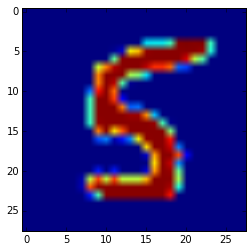

In [135]:
plt.imshow( X_batch[3][0] )

**Now that we have some data, let us define the network and the loss function.**

In [136]:
def siamese_loss(output, y, margin):
    a = output[0::2]
    b = output[1::2]
    d = T.sum((a - b)**2, axis=1)  # this is now a vector with distances for each pair of examples (a, b)
    loss = T.mean(y * d + (1 - y) * T.maximum(margin - d, 0))
    return loss

In [154]:
l_in = InputLayer( (None, 1, 28, 28) )
l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(5,5))
l_pool1 = MaxPool2DLayer(l_conv1, pool_size=(2,2))
l_conv2 = Conv2DLayer(l_pool1, num_filters=32, filter_size=(3,3))
l_pool2 = MaxPool2DLayer(l_conv2, pool_size=(2,2))
l_conv3 = Conv2DLayer(l_pool2, num_filters=32, filter_size=(3,3))
l_final = DenseLayer(l_conv3, num_units=100, nonlinearity=linear)
#l_final = DenseLayer(l_dense, num_units=1, nonlinearity=linear)

In [138]:
X = T.tensor4('X')
y = T.ivector('y')
predictions = lasagne.layers.get_output(l_final, X)
get_out = theano.function([X], predictions)

In [139]:
margin = theano.shared(1.0)
loss = siamese_loss(predictions, y, margin).mean()
get_loss = theano.function([X, y], loss)

In [140]:
params = lasagne.layers.get_all_params(l_final, trainable=True)
params += [margin]
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

In [141]:
train = theano.function([X,y], loss, updates=updates)

In [142]:
for num_iters in range(0, 100):
    X_batch, y_batch = get_batch(size=256)
    print train(X_batch, y_batch)

0.461538605842
0.511483077868
0.481459292788
0.517509032831
0.520932094483
0.514881284372
0.457943886568
0.382307465289
0.401234174293
0.421649300958
0.426793496286
0.338665234028
0.342295435025
0.322744115265
0.283399133298
0.31706911342
0.276625071562
0.242468284973
0.216093685153
0.175890977064
0.156261453214
0.144861402376
0.132905786199
0.102536406202
0.0692482595201
0.0546869173133
0.0340048582282
0.0118656816075
0.000659086675845
0.000877372880671
0.00132740459758
0.000994760280904
0.000683841899381
0.000565981415269
0.00122578386858
0.000690837894332
0.00108447002521
0.000750363653764
0.00104860871145
0.000679668714578
0.000806037718314
0.000626043250015
0.000528483134258
0.000824039103225
0.000681016316993
0.000512315059246
0.000716245108622
0.000686117938332
0.000592906894737
0.000588777262624
0.000744526073449
0.000618598601893
0.000461464600167
0.000535157111729
0.000351276031643
0.000504397705219
0.000517987090895
0.000516423546101
0.000569018764148
0.000523935390363
0.000

KeyboardInterrupt: 

In [146]:
cls_to_idx[0][0:10], cls_to_idx[1][0:10]

([1, 21, 34, 37, 51, 56, 63, 68, 69, 75],
 [3, 6, 8, 14, 23, 24, 40, 59, 67, 70])

In [149]:
identity_pair = np.asarray( [Xt[1], Xt[21]], dtype="float32" ) # (0,0)
imposter_pair = np.asarray( [Xt[1], Xt[3]], dtype="float32" ) # (0, 1)